# Radar processing chain designed for the UK Met Office radar data.

Daniel Sanchez-Rivas<sup>1</sup> and Miguel A. Rico-Ramirez<sup>1</sup>

<sup>1</sup>Department of Civil Engineering, University of Bristol, Bristol, BS8 1TR, United Kingdom

## This notebook describes the process of retrieving, quality-check and processing raw C-band radar data collected by the operational UK Met Office radar network.

UK Met Office C-band rain radar dual-polarisation products are available at http://catalogue.ceda.ac.uk/uuid/82adec1f896af6169112d09cc1174499 (Met Office, 2003)

### Import relevant packages

wradlib is required to compute KDP, comment if not needed.

In [8]:
import numpy as np
import towerpy as tp
import cartopy.crs as ccrs

from wradlib.dp import process_raw_phidp_vulpiani as kdpvpi

%matplotlib notebook

### Define working directory and file name

For this example, we'll use data collected at the Chenies radar site; *augzdr* stands for polarimetric data, *lp* for long-pulse and *el0* refers to collected at 0.5&deg; elevation angle.

In [9]:
rsite = 'chenies'
fdir = f'../datasets/{rsite}/y2020/lpel0/'
fname = (f'metoffice-c-band-rain-radar_{rsite}_202010032105_raw-dual-polar-'
         + 'augzdr-lp-el0.dat')

### Use Towerpy to read in the raw radar variables.

The **Rad_scan class** initialises a radar object. 

Within the **ukmo module**, the *ppi_ukmoraw* function provides an interface to read the current binary format used by the MO to store the radar data.

Note that the argument *exclude_vars* was used to discard the 'W [m/s]', 'SQI [-]' and 'CI [dB]'] variables, as they  will not be used at this stage.

<IPython.core.display.Javascript object>


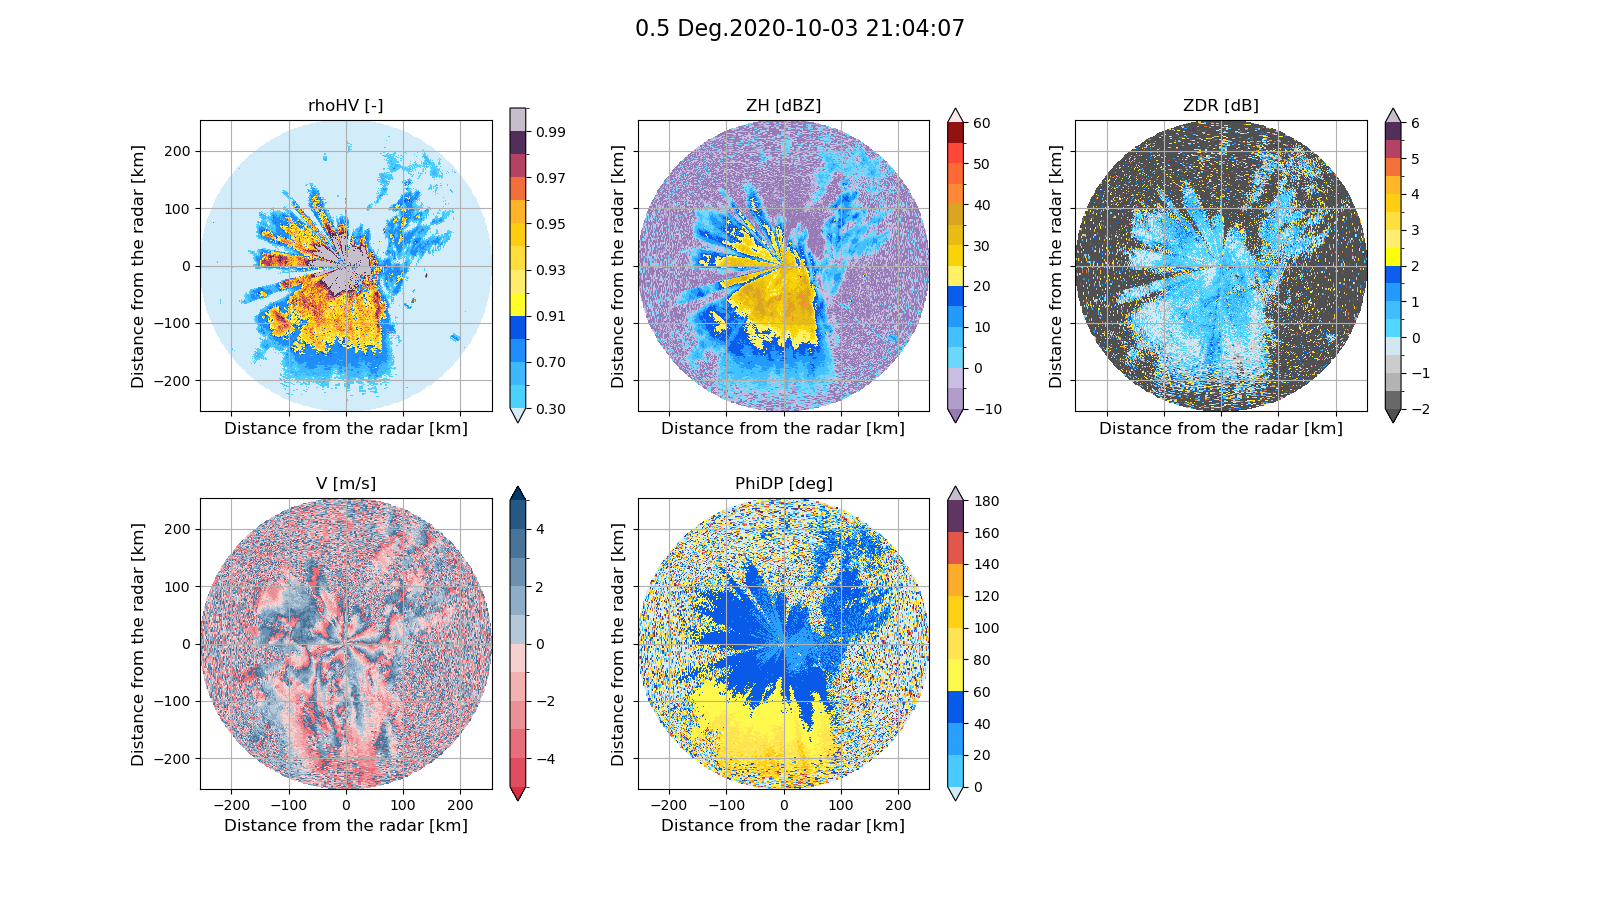

<IPython.core.display.Javascript object>


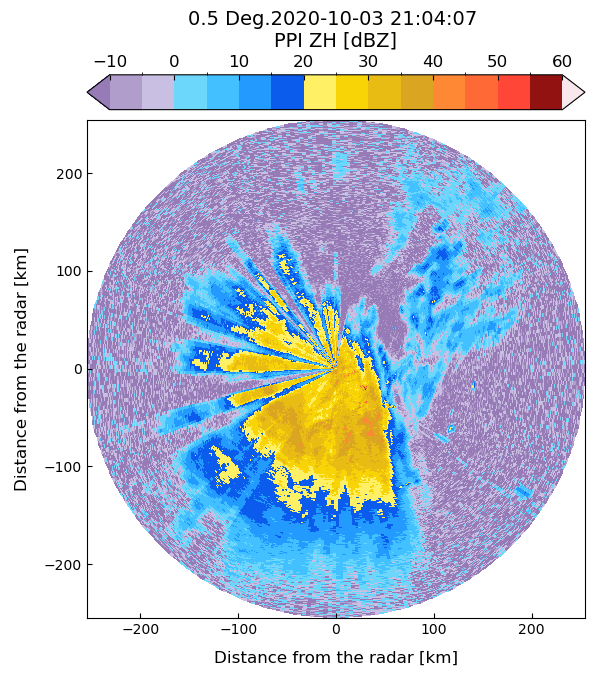

In [12]:
rdata = tp.io.ukmo.Rad_scan(fdir+fname, rsite)
rdata.ppi_ukmoraw(exclude_vars=['W [m/s]', 'SQI [-]', 'CI [dB]'])

# Plot all the radar variables
tp.datavis.rad_display.plot_setppi(rdata.georef, rdata.params, rdata.vars)

# Plot  ZH
tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rdata.vars)

### Compute the Signal-to-Noise-Ratio

Using the *signalnoiseratio* function, we'll compute the Signal-to-Noise-Ratio (SNR) (in dB) and discard data using a reference noise value equal to 35 dB.
This value had been checked at all the UK Met office radar sites (valid only for long-pulse scans) and proved effective in removing noise within the scans.

The *data2correct* argument copies the original data and generates a new dictionary containing radar variables but SNR filtered.

<IPython.core.display.Javascript object>


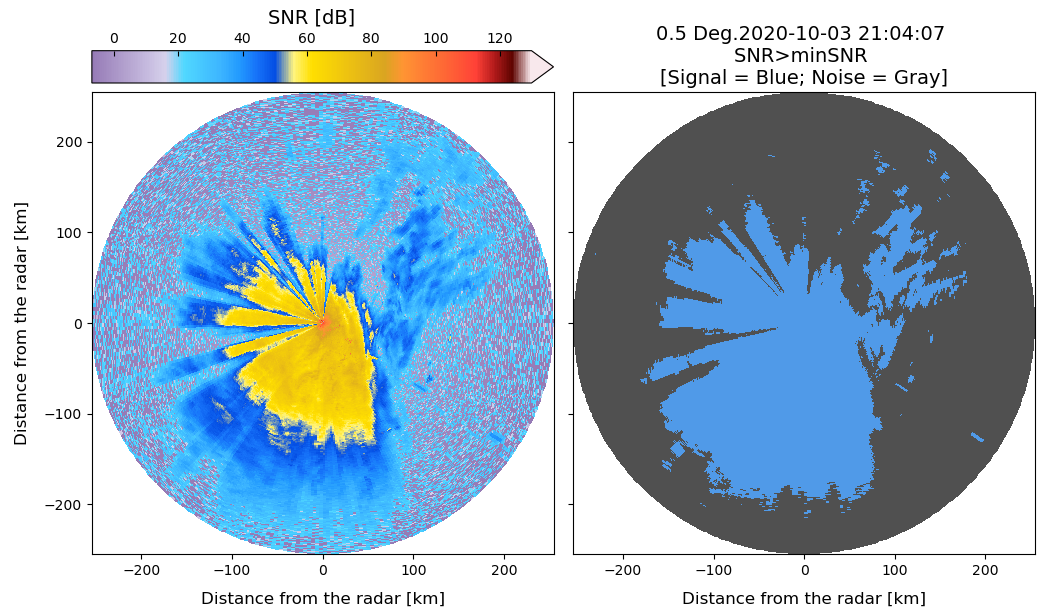

In [11]:
rsnr = tp.eclass.snr.SNR_Classif(rdata)
rsnr.signalnoiseratio(rdata.georef, rdata.params, rdata.vars, min_snr=35,
                      data2correct=rdata.vars, plot_method=True)

### Classification of non-meteorological echoes

Next, 

Clutter classification running time: 0.096 sec.


<IPython.core.display.Javascript object>


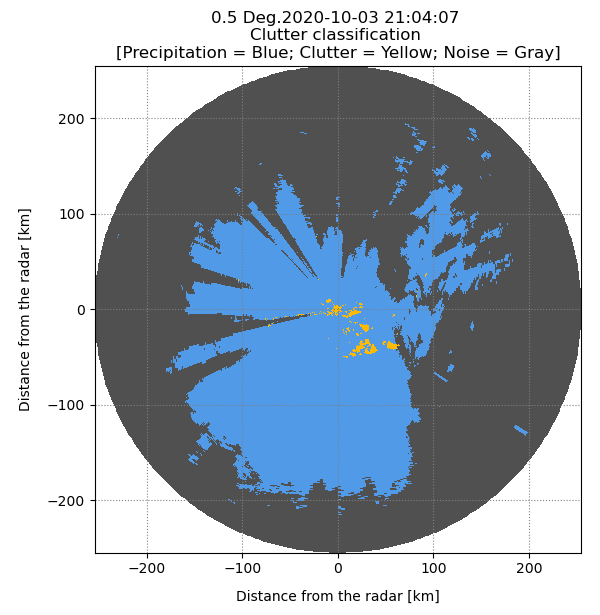

<IPython.core.display.Javascript object>


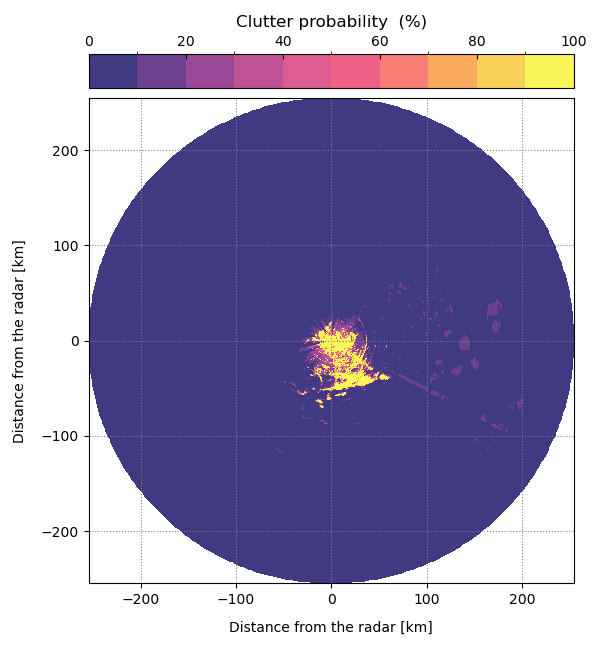

In [6]:
clmap = f'../towerpy/eclass/ukmo_cmaps/{rsite}/chenies_cluttermap_el0.dat'

rnme = tp.eclass.nme.NME_ID(rsnr)
rnme.clutter_id(rdata.georef, rdata.params, rdata.vars, binary_class=223,
                min_snr=rsnr.min_snr, clmap=np.loadtxt(clmap),
                data2correct=rdata.vars, plot_method=True)

In [7]:
# =============================================================================
# Melting layer allocation
# =============================================================================
rmlyr = tp.ml.mlyr.MeltingLayer(rdata)
rmlyr.ml_top = 2
rmlyr.ml_thickness = 0.5

In [8]:
# =============================================================================
# ZDR calibration
# =============================================================================
rczdr = tp.calib.calib_zdr.ZDR_Calibration(rdata)
rczdr.offset_correction(rnme.vars['ZDR [dB]'],
                        zdr_offset=-0.28,
                        data2correct=rnme.vars)

Z_H attenuation correction running time: 0.706 sec.
Z_{DR} attenuation correction running time: 0.168 sec.


<IPython.core.display.Javascript object>


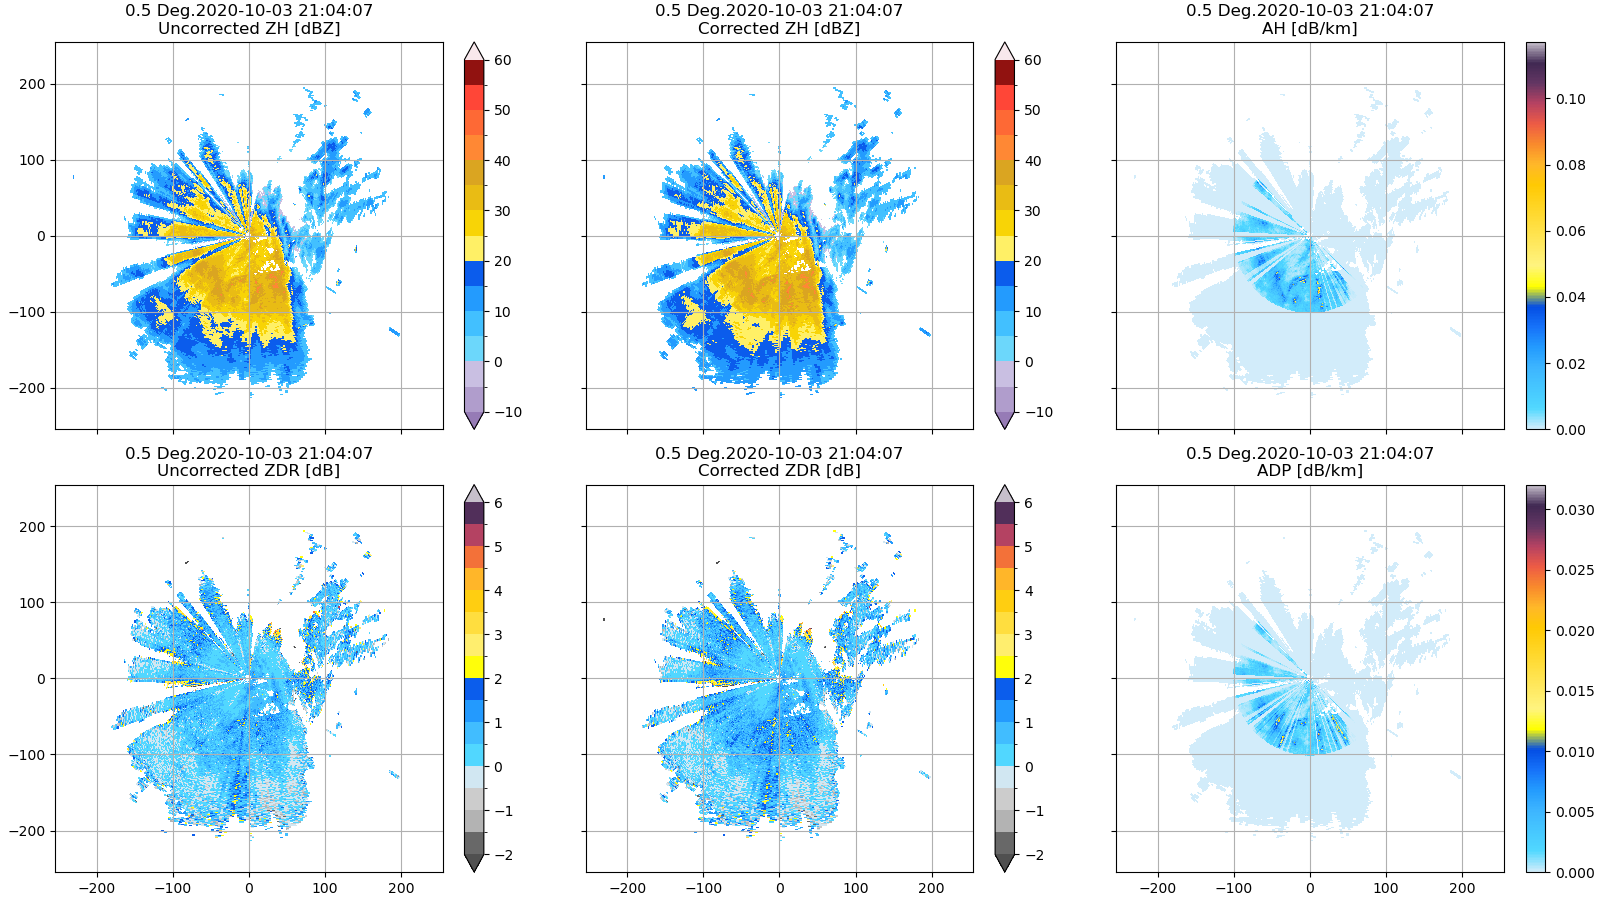

<IPython.core.display.Javascript object>


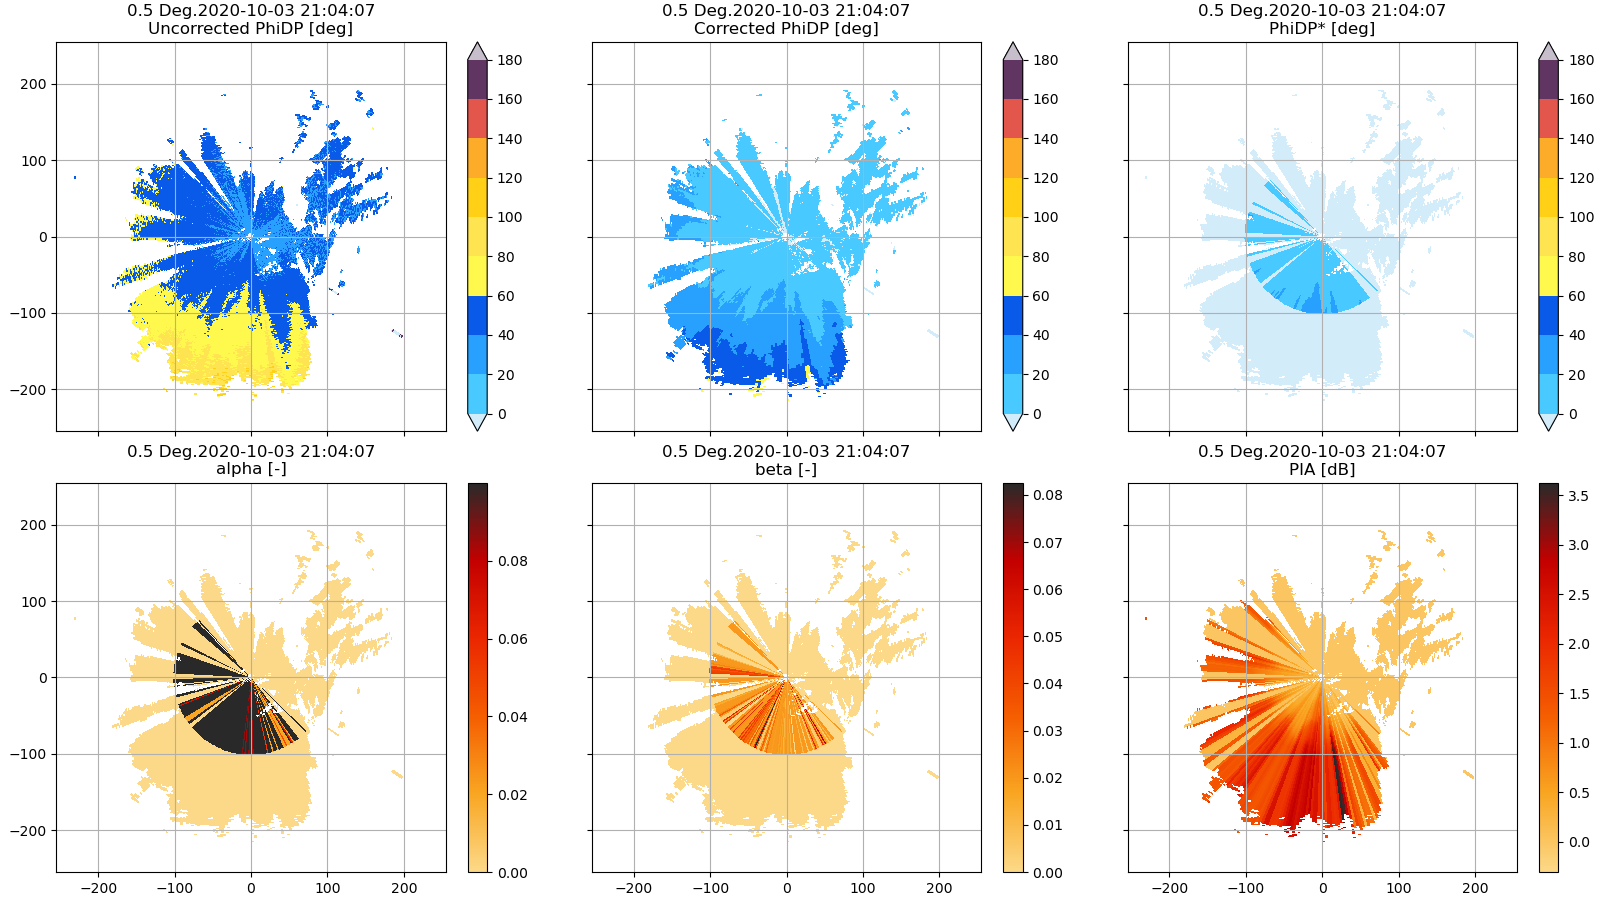

In [9]:
# =============================================================================
# Attenuation correction
# =============================================================================
rattc = tp.attc.attc_zhzdr.AttenuationCorrection(rdata)
rattc.zh_correction(rdata.georef, rdata.params, rczdr.vars,
                    rnme.nme_classif['classif'], attc_method='ABRI',
                    mlyr=rmlyr, pdp_pxavr_azm=1, pdp_dmin=10,
                    pdp_pxavr_rng=round(4000/rdata.params['gateres [m]']))

rattc.zdr_correction(rdata.georef, rdata.params, rczdr.vars, rattc.vars,
                     rnme.nme_classif['classif'], mlyr=rmlyr, rhv_thld=0.98,
                     minbins=10, mov_avrgf_len=5, p2avrf=3,
                     beta_alpha_ratio=.2)

tp.datavis.rad_display.plot_attcorrection(rdata.georef, rdata.params,
                                          rczdr.vars,
                                          rattc.vars)

<IPython.core.display.Javascript object>


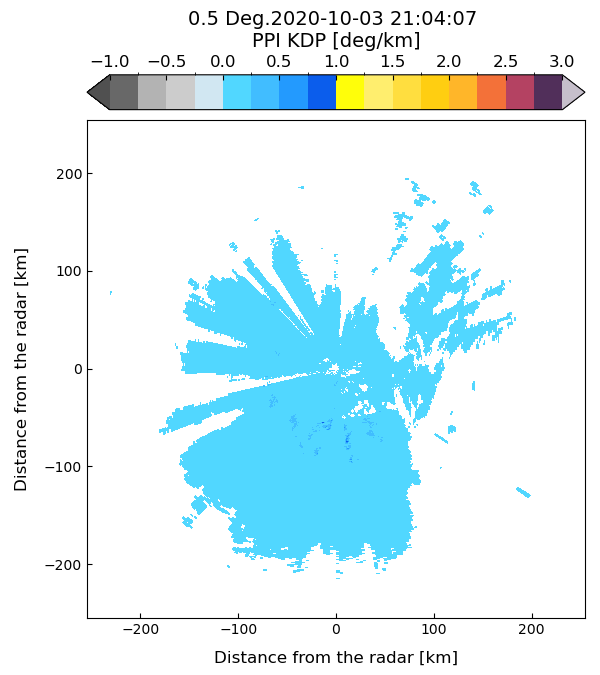

<IPython.core.display.Javascript object>


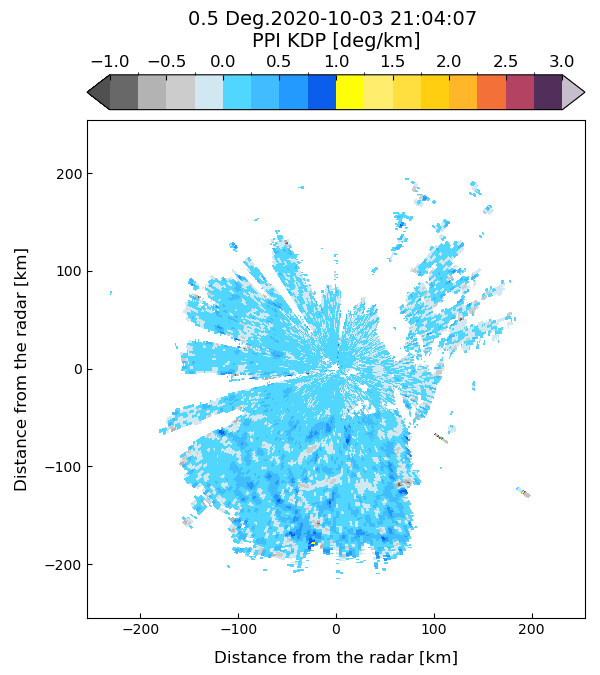

In [10]:
# =============================================================================
# KDP Derivation
# =============================================================================
rkdpv = {}

# KDP Vulpiani
kdp_vulp = kdpvpi(rattc.vars['PhiDP [deg]'], winlen=11,
                  dr=rdata.params['gateres [m]']/1000)
rkdpv['PhiDP [deg]'] = kdp_vulp[0]
rkdpv['KDP [deg/km]'] = kdp_vulp[1]
rkdpv['PhiDP [deg]'][np.isnan(rattc.vars['ZH [dBZ]'])] = np.nan
rkdpv['KDP [deg/km]'][np.isnan(rattc.vars['ZH [dBZ]'])] = np.nan

tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rattc.vars,
                                var2plot='KDP [deg/km]',
                                vars_bounds={'KDP [deg/km]': (-1, 3, 17)})

tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rkdpv,
                                var2plot='KDP [deg/km]',
                                vars_bounds={'KDP [deg/km]': (-1, 3, 17)})

In [11]:
# =============================================================================
# Rainfall estimation
# =============================================================================
rqpe = tp.qpe.qpe_algs.RadarQPE(rdata)

rqpe.z_to_r(rattc.vars['ZH [dBZ]'], a=200, b=1.6, mlyr=rmlyr,
            beam_height=rdata.georef['beam_height [km]'])
rqpe.ah_to_r(rattc.vars['AH [dB/km]'], mlyr=rmlyr,
             beam_height=rdata.georef['beam_height [km]'])
rqpe.z_zdr_to_r1(rattc.vars['ZH [dBZ]'], rattc.vars['ZDR [dB]'], mlyr=rmlyr,
                 beam_height=rdata.georef['beam_height [km]'])
rqpe.z_zdr_to_r2(rattc.vars['ZH [dBZ]'], rattc.vars['ZDR [dB]'], mlyr=rmlyr,
                 a=0.0121, b=0.822, c=-1.7486,
                 beam_height=rdata.georef['beam_height [km]'])
rqpe.kdp_to_r(rkdpv['KDP [deg/km]'], mlyr=rmlyr,
              beam_height=rdata.georef['beam_height [km]'])
rqpe.kdp_zdr_to_r(rkdpv['KDP [deg/km]'], rattc.vars['ZDR [dB]'], mlyr=rmlyr,
                  beam_height=rdata.georef['beam_height [km]'])

<IPython.core.display.Javascript object>


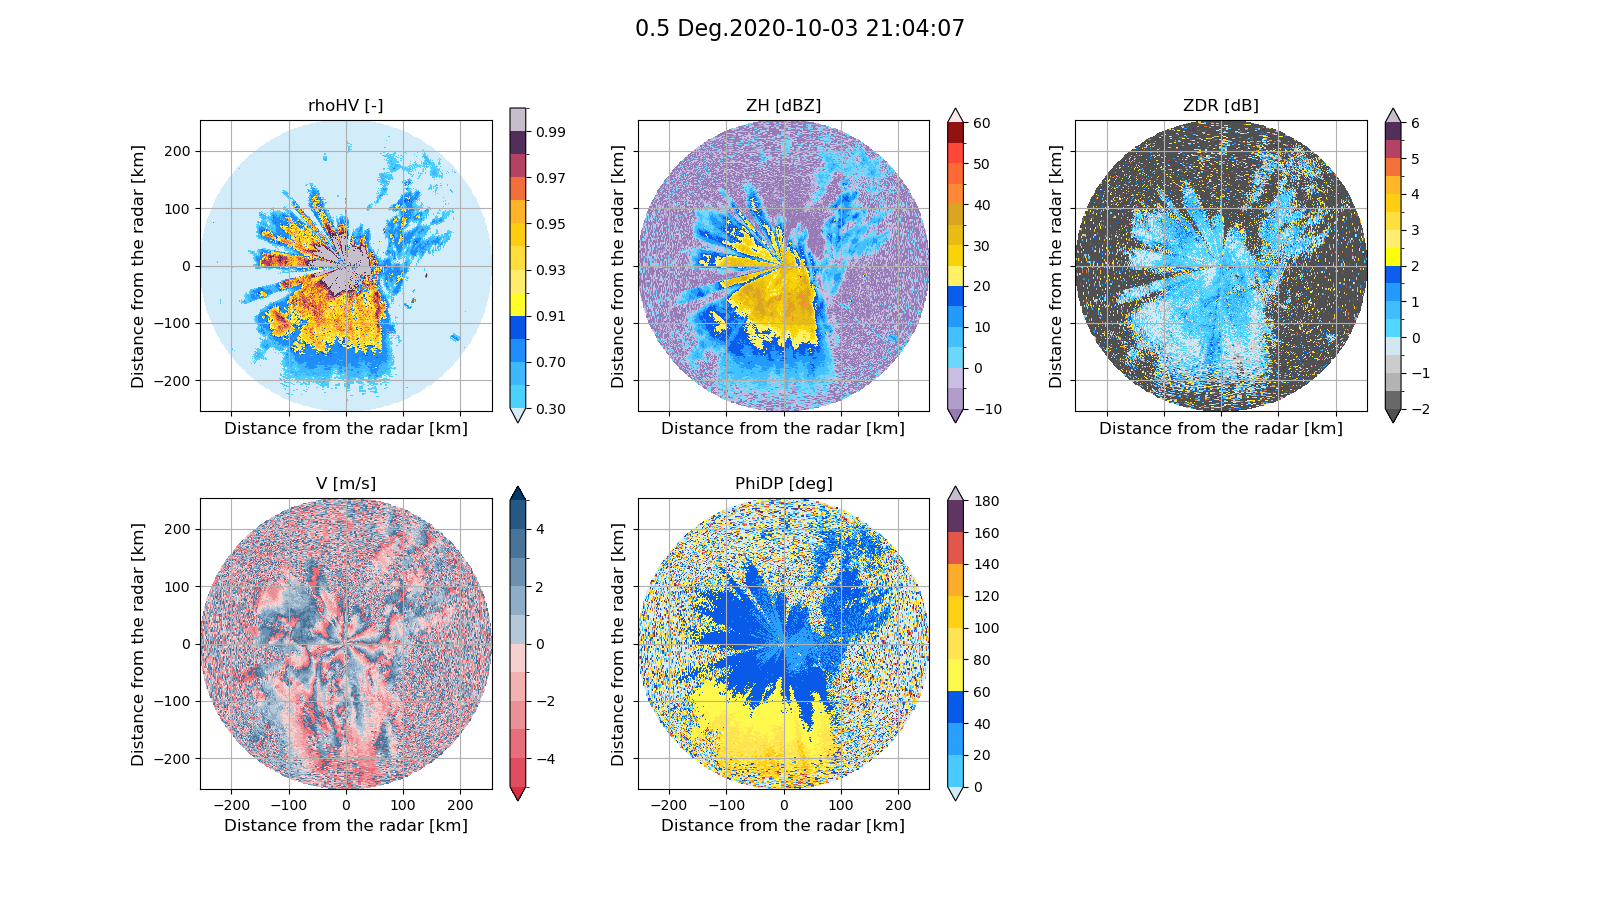

<IPython.core.display.Javascript object>


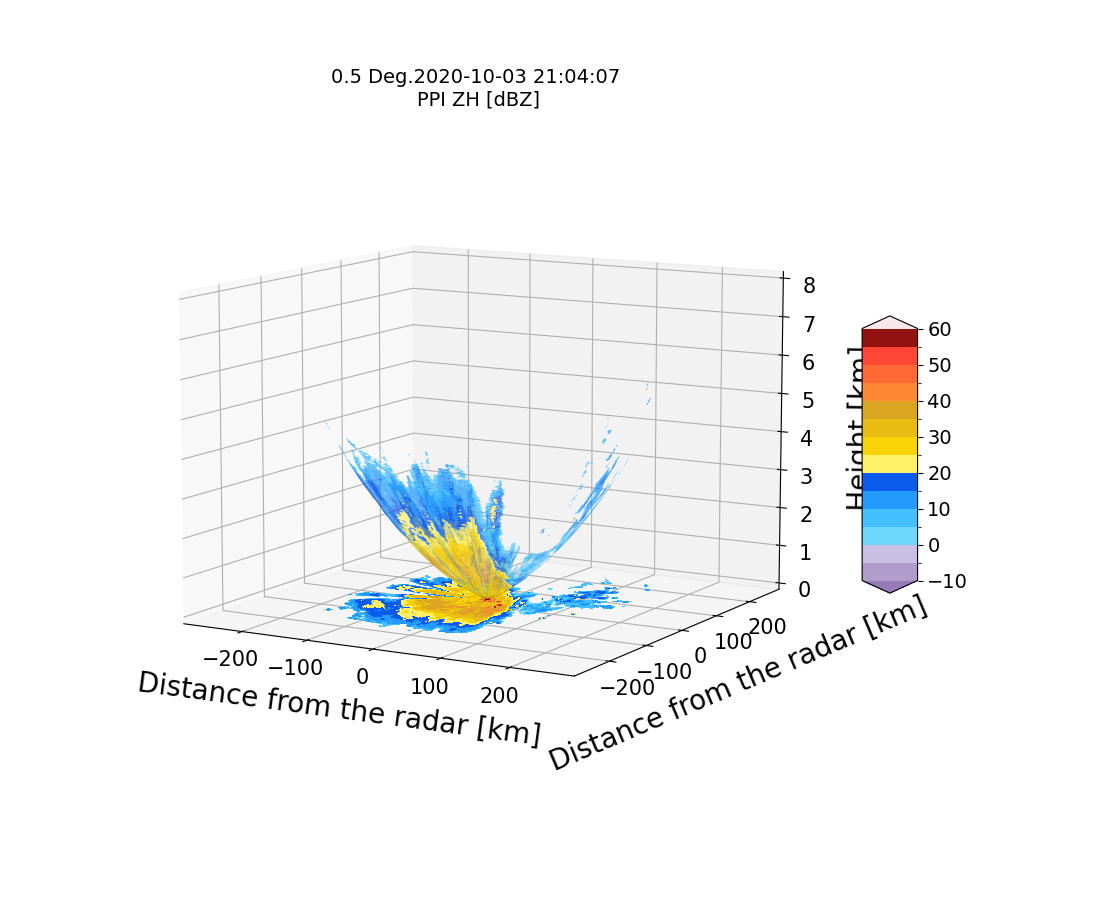

In [12]:
# =============================================================================
# Plots
# =============================================================================
# Plot all the radar variables
tp.datavis.rad_display.plot_setppi(rdata.georef, rdata.params, rdata.vars)

# Plot cone coverage
tp.datavis.rad_display.plot_cone_coverage(rdata.georef, rdata.params,
                                          rsnr.vars)

<IPython.core.display.Javascript object>


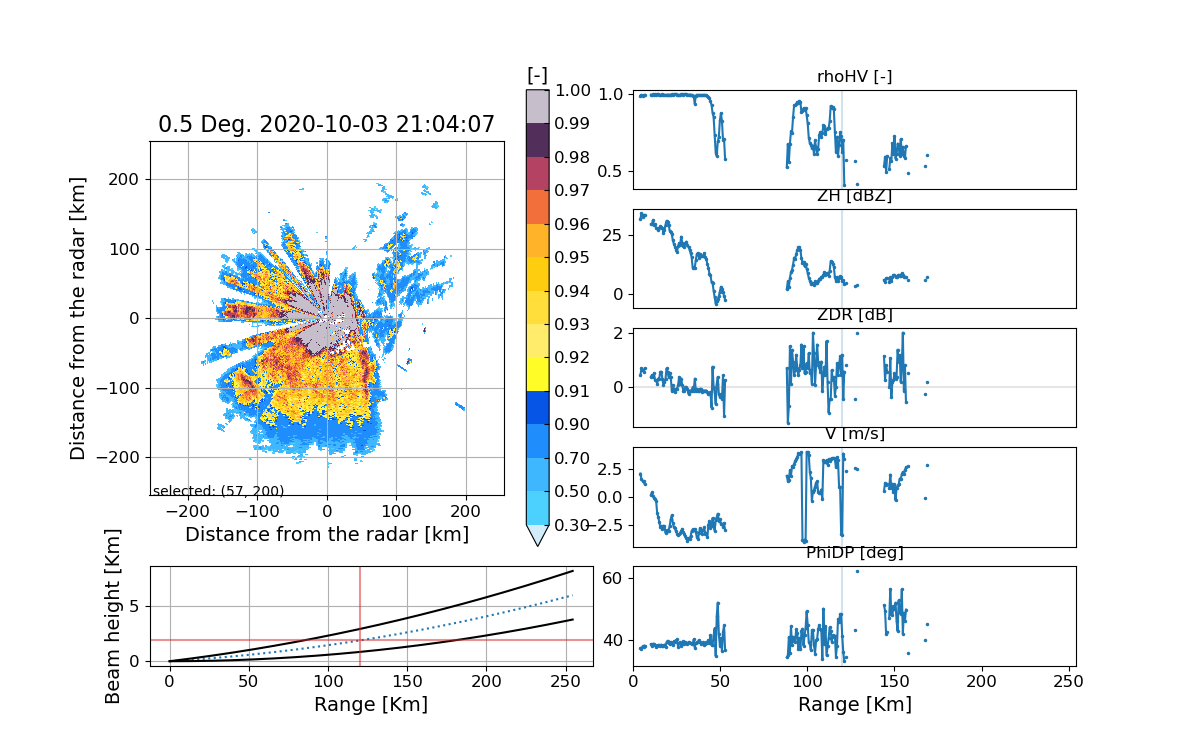


 
 
  Right-click on a pixel within the PPI to select its 
  azimuth or use the n and m keys to browse through the next 
  and previous azimuth. 
  Radial profiles of polarimetric variables will be shown at 
  the axes on the right. 
  Press 0 (MetEchoes) or 5 (NonMetEchoes) to store the       
  coordinates of the current position of the mouse pointer.  
  These coordinate can be retrieved at                       
  ppiexplorer.clickcoords                                    


In [13]:
# Plot an interactive PPI explorer
tp.datavis.rad_interactive.ppi_base(rdata.georef, rdata.params, rnme.vars,
                                    var2plot='rhoHV [-]')
ppiexplorer = tp.datavis.rad_interactive.PPI_Int()
# %%
# ppiexplorer.savearray2binfile(file_name='metoffice-c-band-rain-radar_jersey_202010030735_raw-dual-polar-augzdr-lp-el0.dat',
#                               dir2save='/home/enchiladaszen/Documents/radar_trials/metoffice/')

<IPython.core.display.Javascript object>


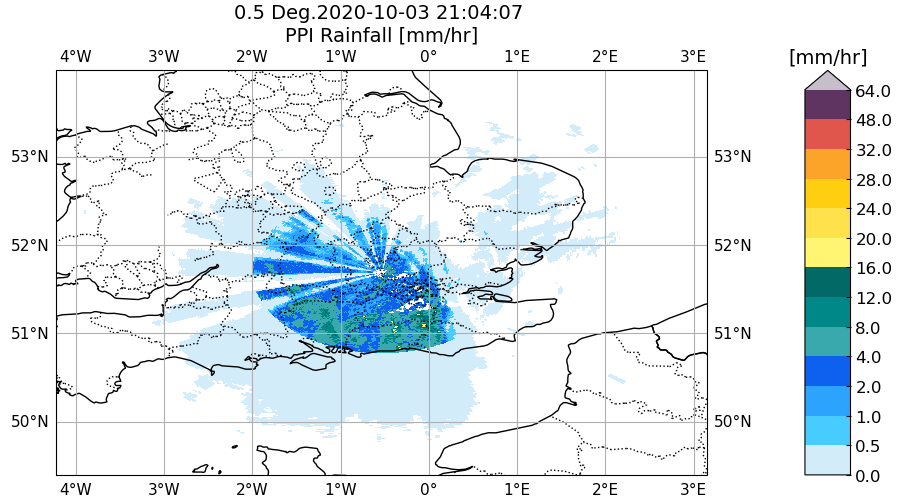

©Natural Earth; license: public domain


In [14]:
# Plot the radar data in a map
xgridp = rdata.georef['xgrid'] + rdata.params['easting [km]']
rdata.georef['xgrid_proj'] = xgridp
ygridp = rdata.georef['ygrid'] + rdata.params['northing [km]']
rdata.georef['ygrid_proj'] = ygridp

rdata.georef['xgrid_proj'] *= 1000
rdata.georef['ygrid_proj'] *= 1000

tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rqpe.r_z,
                                data_proj=ccrs.OSGB(approx=False),
                                cpy_feats={'status': True})

## References

Met Office (2003): Met Office Rain Radar Data from the NIMROD System. NCAS British Atmospheric Data Centre, 2022. http://catalogue.ceda.ac.uk/uuid/82adec1f896af6169112d09cc1174499